# Balance Dataset Analysis

Marcos Duarte

In [5]:
import numpy as np
from scipy.signal import butter, filtfilt
import pandas as pd
pd.set_option('precision', 2)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
sns.set_context("notebook", font_scale=1.4,
                rc={'font.size': 16, 'lines.linewidth': 1, 'lines.markersize': 8, 'axes.titlesize': 'x-large'})
import glob
import sys, os
sys.path.insert(1, r'./../functions')

# IPython widgets:
from IPython.display import display
import ipywidgets
from ipywidgets import FloatProgress, interactive

import qgrid  # pip install git+https://github.com/quantopian/qgrid
qgrid.nbinstall(overwrite=True)  # copies javascript dependencies to /nbextensions folder
qgrid.set_defaults(remote_js=True, precision=2)  # Set default options by calling "set_defaults" (optional)

from AMTIbsf import loadbsf
from psd import psd
from hyperellipsoid import hyperellipsoid

## Load file with metadata about the data set

In [6]:
path = r'./../../../X/BDB/'
fname = 'BDSinfo.txt'
infos = pd.read_csv(os.path.join(path, fname), sep='\t', header=0, index_col=None, engine='c', encoding='utf-8')
print("Information of %s subjects loaded (%s rows, %s columns)."
      %(len(pd.unique(infos.Subject)), infos.shape[0], infos.shape[1]))
qgrid.show_grid(infos.iloc[:, :10])

Information of 231 subjects loaded (2742 rows, 52 columns).


In [7]:
info = infos.drop(labels=['Date', 'Trial', 'Vision', 'Surface'], axis=1)
info.drop_duplicates(subset='Subject', inplace=True)
BMI = info['Weight'].values/(info['Height'].values/100)**2
info['BMI'] = BMI  # info.loc[:, 'BMI'] = pd.Series(BMI, index=info.index)
info['Age2'] = info['Age']
info.Age2.where(info.Age<60, 'Old', inplace=True)
info.Age2.where(info.Age>=60, 'Young', inplace=True)
print('Number of subjects per group')
display(info[['Subject', 'Age2', 'Gender']].groupby(['Age2', 'Gender']).count())
print('Mean values per group')
display(info.groupby(['Age2', 'Gender'])['Age'].mean())
print('STD values per group')
display(info.groupby(['Age2', 'Gender'])['Age'].std())
qgrid.show_grid(info.iloc[:, :10])

Number of subjects per group


Subject
Age2  Gender         
Old   F            75
      M            29
Young F            63
      M            64

Mean values per group


Age2   Gender
Old    F         71.77
       M         69.80
Young  F         27.98
       M         30.80
Name: Age, dtype: float64

STD values per group


Age2   Gender
Old    F          6.88
       M          6.20
Young  F          7.80
       M         10.05
Name: Age, dtype: float64

In [8]:
display(info[['Subject', 'Age2', 'PWD', 'Illness']].groupby(['Age2', 'PWD', 'Illness']).count())

Subject
Age2  PWD Illness         
Old   No  No            14
          Yes           74
      Yes No             2
          Yes           14
Young No  No            71
          Yes           50
      Yes No             2
          Yes            4

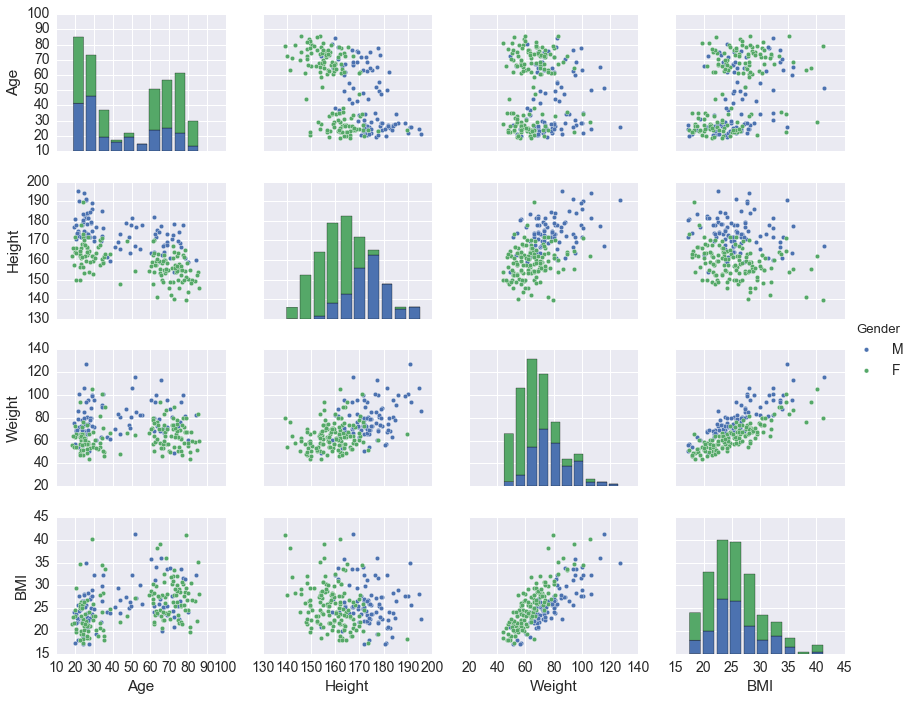

In [9]:
#from pandas.tools.plotting import scatter_matrix
#scatter_matrix(info[['Age', 'Height', 'Weight']], alpha=0.8, figsize=(15, 12), color='DarkBlue', diagonal='kde');
#plt.figure(figsize=(15, 12))
axs = sns.pairplot(info[['Age', 'Gender', 'Height', 'Weight', 'BMI']], hue='Gender', dropna=True, size=2.5, aspect=1.2)
plt.show()